# Self-Driving Car Engineer Nanodegree
***

## Project: **Advanced Lane Line Detection** 
***

In this project, advanced lane line detection pipeline will be implemented and tested on static images and video streams.

First, parameters of camera calibration should be estimated through the following steps:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Save the estimated parameters for deployment.

The advanced lane line detection works as follows:
1. Apply a distortion correction to raw images.
2. Create a thresholded binary image using color transforms, gradients, etc.
3. Apply a perspective transform to rectify binary image ("birds-eye view").
4. Detect lane pixels and fit to find the lane boundary.
5. Determine the curvature of the lane and vehicle position with respect to center.
6. Warp the detected lane boundaries back onto the original image.
7. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Set Up Session

In [1]:
# Configuration file:
from lane_line_detection.utils.conf import Conf
# IO utilities:
import random
import glob
from os.path import basename, splitext
import json
import pickle
# Image processing:
import numpy as np
import matplotlib.image as mpimg
import cv2
from lane_line_detection.rectifiers import DistortionRectifier
from lane_line_detection.transformers import PerspectiveTransformer
from lane_line_detection.binarizers import Binarizer
from lane_line_detection.analyzers import Analyzer
from lane_line_detection.analyzers import StreamAnalyzer
from lane_line_detection.painters import Painter
# Visualization:
import matplotlib.pyplot as plt
%matplotlib inline

## Load Configuration

In [2]:
conf = Conf("conf/conf.json")

## Build Distortion Rectifier

***

First, estimate camera distortion from chessboard images and build the rectifier for deployment. Two images would fail the chessboard detection test due to the poor imaging of the contained chessboard pattern.

The attained rectifier will be dumped as pickle file for further access.


In [3]:
# Build:
rectifier = DistortionRectifier(
    conf.calibration_images_descriptor
)

# Save for deployment:
with open(conf.calibration_rectifier_pickle, "wb") as rectifier_pkl:
    pickle.dump(rectifier, rectifier_pkl)

[Calibration 05]: Failed--camera_calibration/calibration5--9-by-6.jpg


[Calibration 04]: Failed--camera_calibration/calibration4--9-by-6.jpg


Below are one sample chessboard image and its rectified view:

In [4]:
# Load rectifier:
with open(conf.calibration_rectifier_pickle, "rb") as rectifier_pkl:
    rectifier = pickle.load(rectifier_pkl)
    
# Rectify all test images:
for test_image_filename in glob.glob(conf.test_images):
    test_image = cv2.imread(
        test_image_filename
    )
    filename, ext = splitext(basename(test_image_filename))
    cv2.imwrite(
        "output_images/{}-rectified{}".format(filename, ext),
        rectifier.transform(test_image)
    )

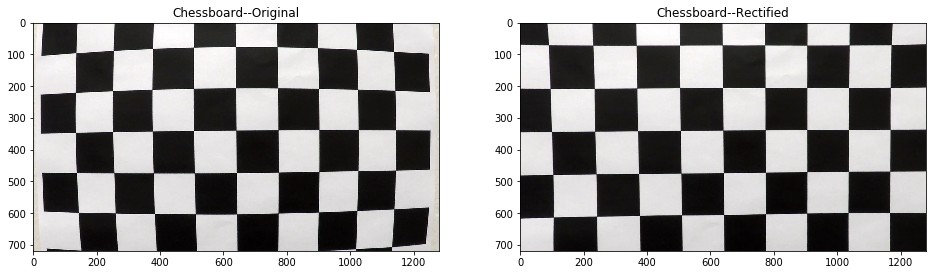

In [5]:
# Original & rectified:
image_sample_original = mpimg.imread("camera_calibration/calibration1--9-by-5.jpg")
image_sample_rectified = rectifier.transform(
    image_sample_original
)

# Initialize canvas:
image_rectification_demo = plt.figure(figsize=(16, 9))

# Original:
ax=image_rectification_demo.add_subplot(1,2,1)
plt.imshow(image_sample_original)
ax.set_title("Chessboard--Original")
# Rectified:
ax=image_rectification_demo.add_subplot(1,2,2)
plt.imshow(image_sample_rectified)
ax.set_title("Chessboard--Rectified")

We notice that after rectification, the glitches in the original chessboard image have been successfully removed 

## Identify the Trapezoidal Zone for Pespective Transform

***

Next I would identify the trapezoidal zone needed for pespective transform.

To select the appropriate four points for trapezoidal zone, I first annotated all the straight-line test images using [Sloth](https://github.com/cvhciKIT/sloth)

The required points could be attained through statistical analysis of annotation result

In [6]:
# Analyze annotation results:
import json

# Extract:
with open(conf.perspective_transform_trapezoidal_annotation) as trapezoidal_annotation_file:    
    trapezoidal_annotations = json.load(trapezoidal_annotation_file)

# Transform
X, Y = [], []
for annotation in trapezoidal_annotations:
    X.append(annotation["annotations"][0]["xn"].split(';'))
    Y.append(annotation["annotations"][0]["yn"].split(';'))
X = np.array(X, dtype=np.float)
Y = np.array(Y, dtype=np.float)

# Analyze:
for name, point in zip(
    ("Top-Right", "Top-Left", "Bottom-Left", "Bottom-Right"),
    zip(
        X.mean(axis=0), 
        Y.mean(axis=0)
    )
):
    x_relative, y_relative = point
    print(
        "[{:>12}]: ({:.1f}, {:.1f})".format(
            name, x_relative, y_relative
        )
    )

[   Top-Right]: (689.1, 452.1)
[    Top-Left]: (594.2, 452.1)
[ Bottom-Left]: (246.5, 696.8)
[Bottom-Right]: (1069.7, 696.8)


Based on the above analysis, my final four-point perspective transformation pairs are as follows:

```json
	"perspective_transform_source": [
		[ 689.1, 452.1],
		[ 594.2, 452.1],
		[ 246.5, 696.8],
		[1069.7, 696.8]
	],
	"perspective_transform_destination": [
        [   960,     1],
        [   320,     1],
        [   320,   718],
        [   960,   718]
	]
```

The above parameters have all been saved in the json configuration file

In [7]:
# Build:
transformer = PerspectiveTransformer(
    conf.perspective_transform_source,
    conf.perspective_transform_destination,
    tuple(conf.frame_size)
)

# Save for deployment:
with open(conf.perspective_transformer_pickle, "wb") as transformer_pkl:
    pickle.dump(transformer, transformer_pkl)

In [8]:
# Build painter:
painter = Painter(transformer)

# Save for deployment:
with open(conf.painter_pickle, "wb") as painter_pkl:
    pickle.dump(painter, painter_pkl)

In [9]:
# Load transformer:
with open(conf.perspective_transformer_pickle, "rb") as transformer_pkl:
    transformer = pickle.load(transformer_pkl)

In [10]:
# Load transformer:
with open(conf.painter_pickle, "rb") as painter_pkl:
    painter = pickle.load(painter_pkl)

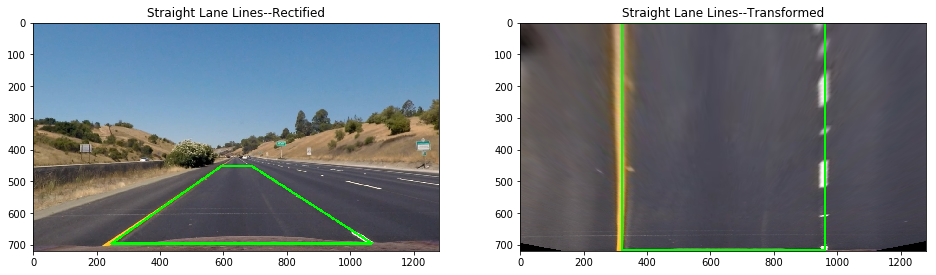

In [11]:
# Original & rectified:
image_sample_original = mpimg.imread("test_images/straight-lines01.jpg")
image_sample_rectified = rectifier.transform(
    image_sample_original
)
image_sample_transformed = transformer.transform(
    image_sample_rectified
)

# Initialize canvas:
perspective_transformation_demo = plt.figure(figsize=(16, 9))

# Original:
ax=perspective_transformation_demo.add_subplot(1,2,1)
plt.imshow(
    cv2.polylines(
        image_sample_rectified, 
        [
            np.array(
                conf.perspective_transform_source,
                dtype=np.int
            )
        ], 
        True,
        (0, 255, 0),
        6
    )
)
ax.set_title("Straight Lane Lines--Rectified")
# Rectified:
ax=perspective_transformation_demo.add_subplot(1,2,2)
plt.imshow(
    cv2.polylines(
        image_sample_transformed, 
        [
            np.array(
                conf.perspective_transform_destination,
                dtype=np.int
            )
        ], 
        True,
        (0, 255, 0),
        6
    )
)
ax.set_title("Straight Lane Lines--Transformed")

## Build Binarizer

***

Here I threshold the image based on:

1. The magnitude of grad_x;
2. The value of saturation;


In [12]:
# Build:
binarizer = Binarizer(
    conf.frame_size,
    conf.binarizer_ROI,
    conf.binarizer_yellow_lane_hue_thresholds,
    conf.binarizer_yellow_lane_saturation_thresholds,
    conf.binarizer_white_lane_saturation_thresholds,
    conf.binarizer_white_lane_value_thresholds,
    conf.binarizer_gradient_kernel_size,
    conf.binarizer_gradient_thresholds,
    conf.binarizer_morphology_kernel_size
)

# Save for deployment:
with open(conf.binarizer_pickle, "wb") as binarizer_pkl:
    pickle.dump(binarizer, binarizer_pkl)

In [13]:
# Load binarizer:
with open(conf.binarizer_pickle, "rb") as binarizer_pkl:
    binarizer = pickle.load(binarizer_pkl)

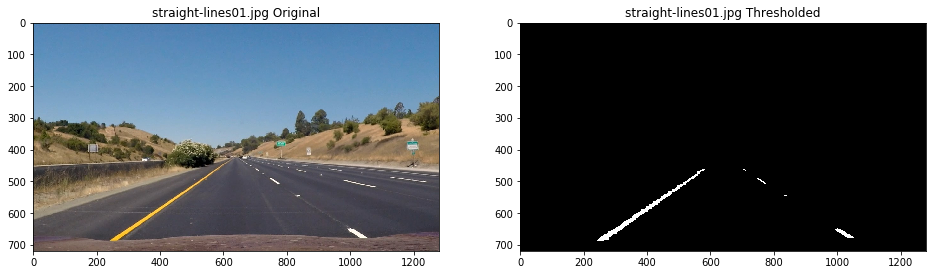

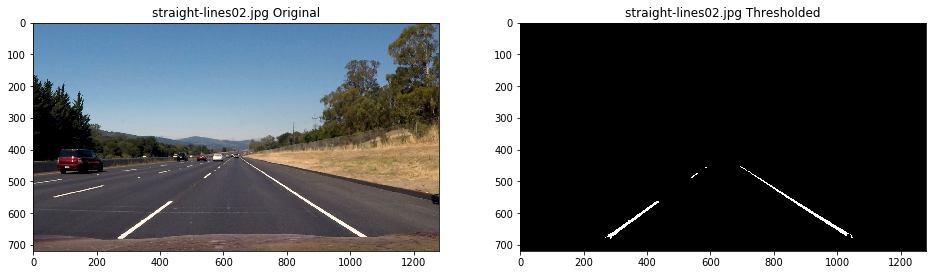

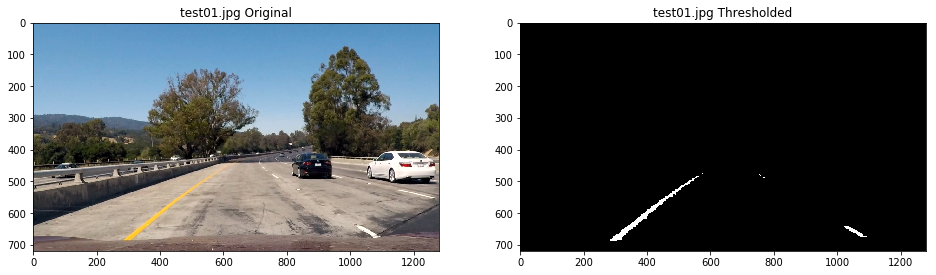

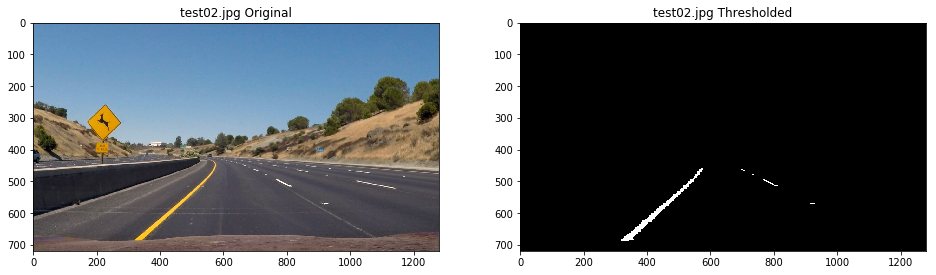

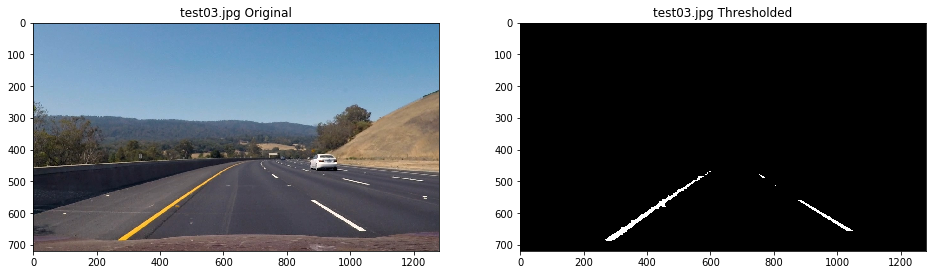

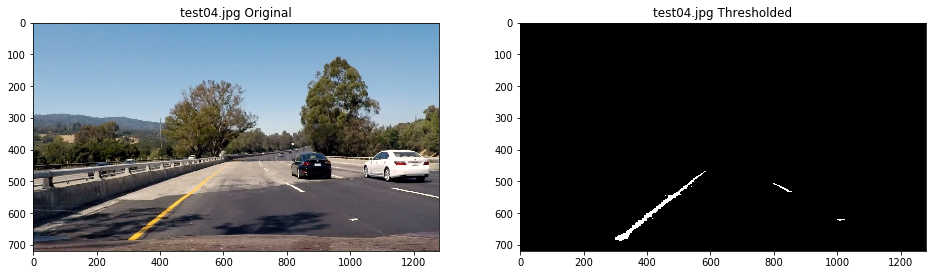

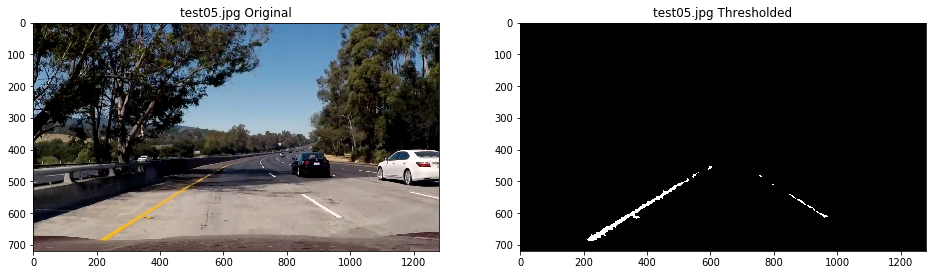

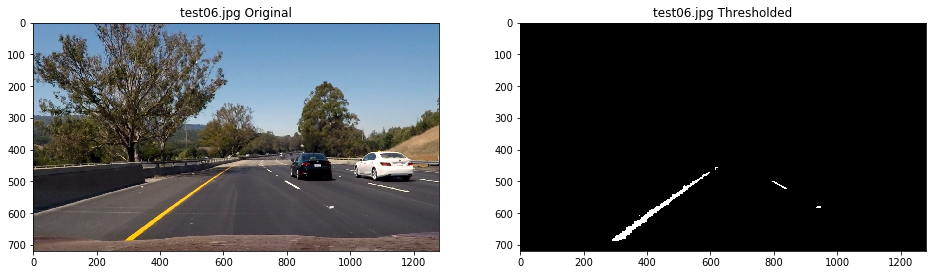

In [14]:
for image_filename in sorted(glob.glob(conf.test_images)):
    # Binarized & transformed:
    image_sample_original = cv2.imread(
        image_filename
    )
    image_sample_rectified = rectifier.transform(
        image_sample_thresholded
    )
    '''
    image_sample_thresholded = binarizer.transform(
        image_sample_original
    )
    image_sample_rectified = rectifier.transform(
        image_sample_thresholded
    )
    image_sample_transformed = transformer.transform(
        image_sample_rectified
    )
    '''

    # Initialize canvas:
    thresholding_demo = plt.figure(figsize=(16, 9))

    # Original:
    ax=thresholding_demo.add_subplot(1,2,1)
    plt.imshow(
        cv2.cvtColor(image_sample_original, cv2.COLOR_BGR2RGB)
    )
    ax.set_title("{} Original".format(basename(image_filename)))
    # Rectified:
    ax=thresholding_demo.add_subplot(1,2,2)
    plt.imshow(
        cv2.cvtColor(image_sample_rectified, cv2.COLOR_BGR2RGB)
    )
    ax.set_title("{} Rectified".format(basename(image_filename)))

## Build Lane Analyzer

***

Here I choose to implement linear SVM using LinearSVC because the dimensions of training dataset,(35520, -1), is formidable. Use SVC will lead to a very slow training process.

In [15]:
# Build:
analyzer = Analyzer(
    conf.analyzer_window_size,
    conf.analyzer_offset,
    conf.analyzer_meter_per_pix
)

# Save for deployment:
with open(conf.analyzer_pickle, "wb") as analyzer_pkl:
    pickle.dump(analyzer, analyzer_pkl)

In [16]:
# Load analyzer:
with open(conf.analyzer_pickle, "rb") as analyzer_pkl:
    analyzer = pickle.load(analyzer_pkl)

## Test on Static Images

In [17]:
def process_image(image_sample_original):
    # Step 1--Rectify
    image_sample_rectified = rectifier.transform(
        image_sample_original
    )
    # Step 2--Threshold
    image_sample_thresholded = binarizer.transform(
        image_sample_rectified
    )
    # Step 3--Warp:
    image_sample_transformed = transformer.transform(
        image_sample_thresholded
    )

    # Step 4--Get lane line params:
    params = analyzer.transform(image_sample_transformed)
    
    # Step 5--Inpainting
    if params is None:
        image_sample_processed = image_sample_rectified
    else:
        (lane_line_params, curverads, offset) = params
        image_sample_processed = painter.transform(
            image_sample_rectified,
            lane_line_params,
            curverads,
            offset
        )
    
    return image_sample_processed

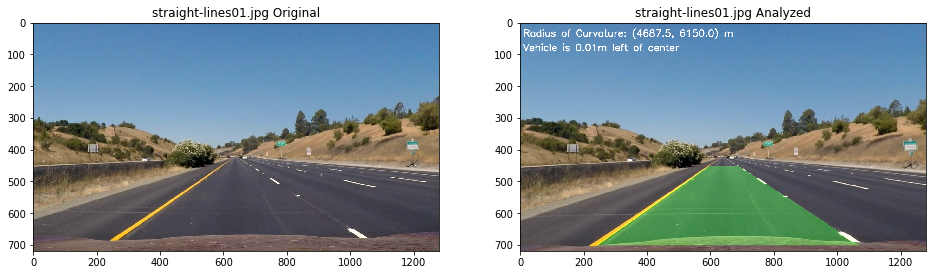

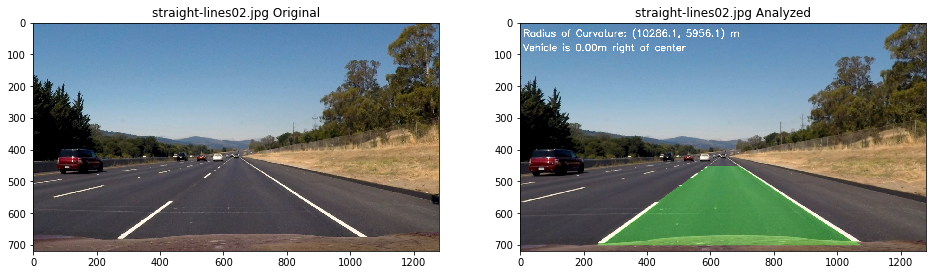

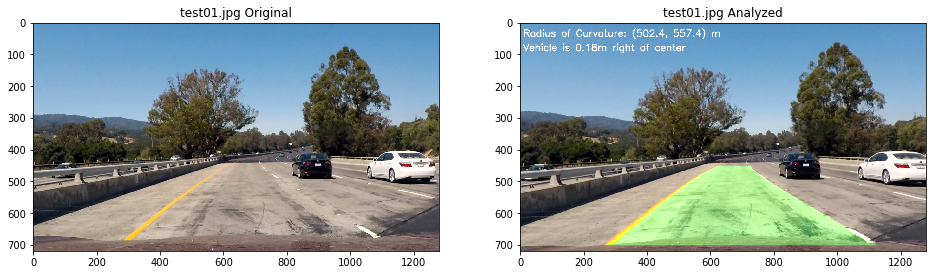

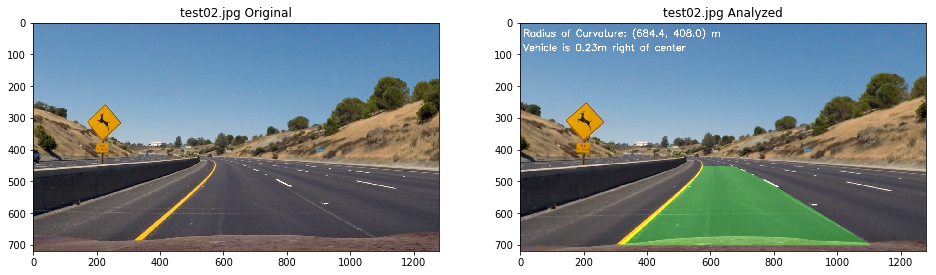

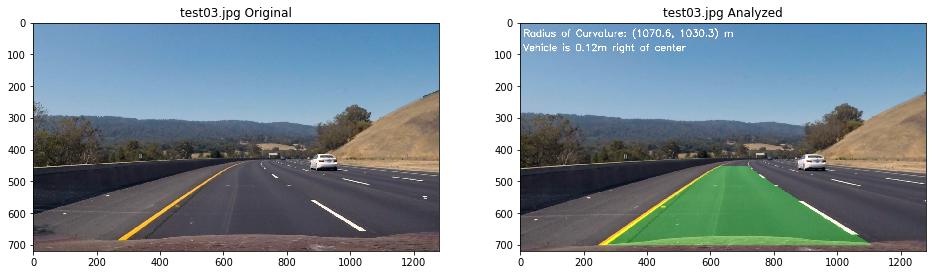

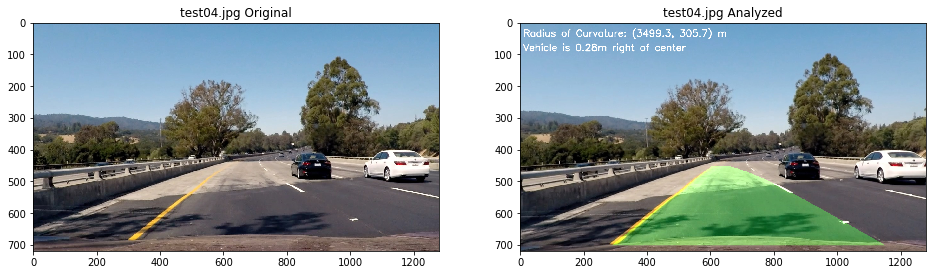

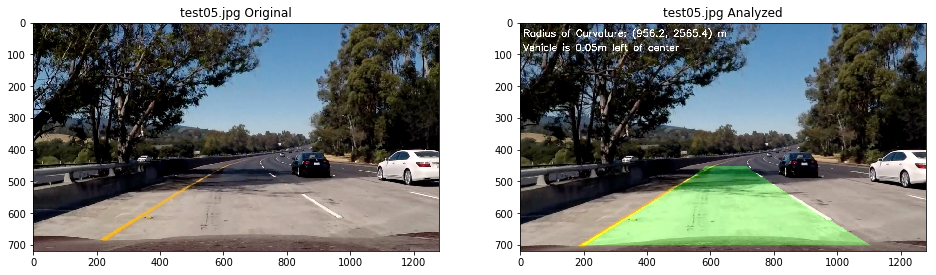

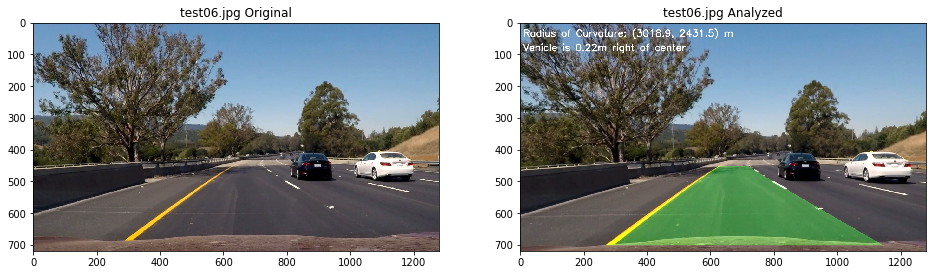

In [18]:
for image_filename in sorted(glob.glob(conf.test_images)):
    image_sample_original = cv2.imread(image_filename)
    image_sample_processed = process_image(image_sample_original)
    
    # Initialize canvas:
    lane_analysis_demo = plt.figure(figsize=(16, 9))

    # Original:
    ax=lane_analysis_demo.add_subplot(1,2,1)
    plt.imshow(
        cv2.cvtColor(
            image_sample_original,
            cv2.COLOR_BGR2RGB
        )
    )
    ax.set_title("{} Original".format(basename(image_filename)))
    # Rectified:
    ax=lane_analysis_demo.add_subplot(1,2,2)
    plt.imshow(
        cv2.cvtColor(
            image_sample_processed,
            cv2.COLOR_BGR2RGB
        )
    )
    ax.set_title("{} Analyzed".format(basename(image_filename)))

## Test on Videos

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from multiprocessing import Pool
from moviepy.editor import concatenate_videoclips
from IPython.display import HTML

In [20]:
# Build:
stream_analyzer = StreamAnalyzer(
    conf.analyzer_window_size,
    conf.analyzer_offset,
    conf.analyzer_meter_per_pix,
    conf.stream_analyzer_temporal_filter_len
)

# Save for deployment:
with open(conf.stream_analyzer_pickle, "wb") as stream_analyzer_pkl:
    pickle.dump(stream_analyzer, stream_analyzer_pkl)

In [21]:
# Load analyzer:
with open(conf.stream_analyzer_pickle, "rb") as stream_analyzer_pkl:
    stream_analyzer = pickle.load(stream_analyzer_pkl)

In [22]:
def process_frame(frame):    
    # Step 0--Format:
    original = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

    # Step 1--Rectify
    rectified = rectifier.transform(
        original
    )
    # Step 2--Threshold
    thresholded = binarizer.transform(
        rectified
    )
    # Step 3--Warp:
    transformed = transformer.transform(
        thresholded
    )

    # Step 4--Get lane line params:
    params = stream_analyzer.transform(transformed)
    
    # Step 5--Inpainting
    (lane_line_params, curverads, offset) = params
    processed = painter.transform(
        rectified,
        lane_line_params,
        curverads,
        offset
    )
    
    return cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)

### Project Video

In [ ]:
# IO config:
video_project_input = "test_videos/project_video.mp4"
video_project_output = "output_videos/project_video_detected.mp4"

In [ ]:
### Process:
clip_project = VideoFileClip(video_project_input)
clip_project_detected = clip_project.fl_image(process_frame)
%time clip_project_detected.write_videofile(video_project_output, audio=False)

In [ ]:
# Display:
HTML(
    """
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(video_project_output)
)

### Challenge Video

In [23]:
# IO config:
video_challenge_input = "test_videos/challenge_video.mp4"
video_challenge_output = "output_videos/challenge_video_detected.mp4"

In [24]:
### Process:
clip_challenge = VideoFileClip(video_challenge_input)
clip_challenge_detected = clip_challenge.fl_image(process_frame)
%time clip_challenge_detected.write_videofile(video_challenge_output, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video_detected.mp4
[MoviePy] Writing video output_videos/challenge_video_detected.mp4


100%|██████████| 485/485 [01:04<00:00,  7.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video_detected.mp4 

CPU times: user 6min 15s, sys: 4.41 s, total: 6min 19s
Wall time: 1min 5s


In [25]:
# Display:
HTML(
    """
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(video_challenge_output)
)